#  Goal 
Predict Houses Price According To Some Features

# Libs

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import pingouin
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)})
sns.set_palette('viridis')
import matplotlib.pyplot as plt
from datasist.structdata import detect_outliers
import warnings
warnings.filterwarnings('ignore')

# Data Collecting

In [ ]:
df = pd.read_csv("../data/housePrice.csv")
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


# Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [4]:
#Consider price in dollars only
df.drop(columns=['Price'],inplace=True)
df.rename(columns={'Price(USD)':'Price'},inplace=True)
df.dropna(subset=['Address'],inplace=True)

In [5]:
df.duplicated().sum()

208

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.nunique()

Area         243
Room           6
Parking        2
Warehouse      2
Elevator       2
Address      192
Price        928
dtype: int64

In [8]:
df.loc[df['Area'].str.contains(',')]

,Area,Room,Parking,Warehouse,Elevator,Address,Price
570,"3,310,000,000",2,True,True,True,Ostad Moein,110333.33
709,"16,160,000,000",3,True,True,True,Pasdaran,538666.67
807,"1,000",2,True,True,False,Damavand,233333.33
1604,"8,400,000,000",2,True,True,True,Gheitarieh,290000.00
2171,"3,600",2,False,False,False,Shahryar,324000.00
2802,"2,550,000,000",2,True,True,True,Central Janatabad,85000.00


In [9]:
df.drop(index=df.loc[df['Area'].str.contains(',')].index,inplace=True)

In [10]:
df['Area'] = df['Area'].astype('int')

In [11]:
df.describe()

,Area,Room,Price
count,3242.000000,3242.000000,3.242000e+03
mean,107.701110,2.087909,1.824541e+05
std,70.935755,0.765248,2.757539e+05
min,30.000000,0.000000,1.200000e+02
25%,70.000000,2.000000,4.733333e+04
50%,90.000000,2.000000,9.900000e+04
75%,121.000000,2.000000,2.052500e+05
max,929.000000,5.000000,3.080000e+06


In [12]:
#Unlogical to own house with 0 rooms, replace with 1 room
df.loc[df['Room']==0,'Room'] = 1

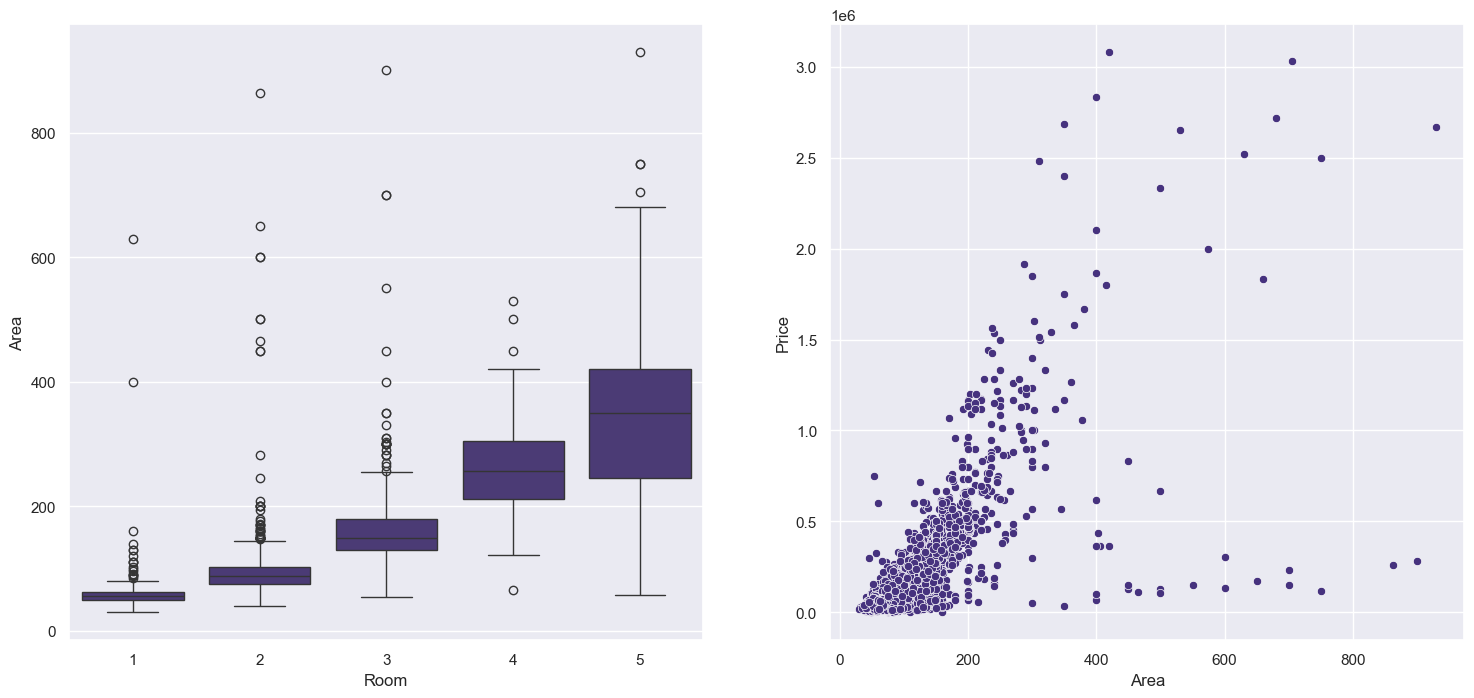

In [13]:
fig,axs = plt.subplots(1,2)
sns.boxplot(data=df,x='Room',y='Area',ax=axs[0])
sns.scatterplot(data=df,x='Area',y='Price',ax=axs[1])
plt.show()

Some Areas seems unlogical such as house with 1 room with area 600+, Let's see

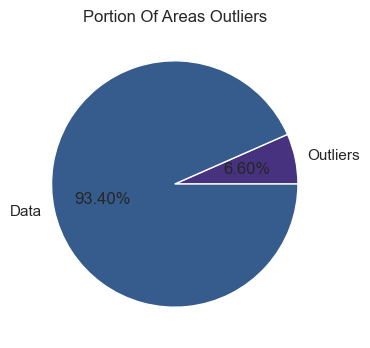

In [14]:
idxs = detect_outliers(df,0,features=['Area'])
plt.figure(figsize=(4,4))
plt.pie([len(idxs),len(df)],autopct='%.2f%%',labels=['Outliers','Data'])
plt.title('Portion Of Areas Outliers')
plt.show()

In [15]:
#Since they are a small portion we can ignore them in data
df.drop(index=idxs,inplace=True)

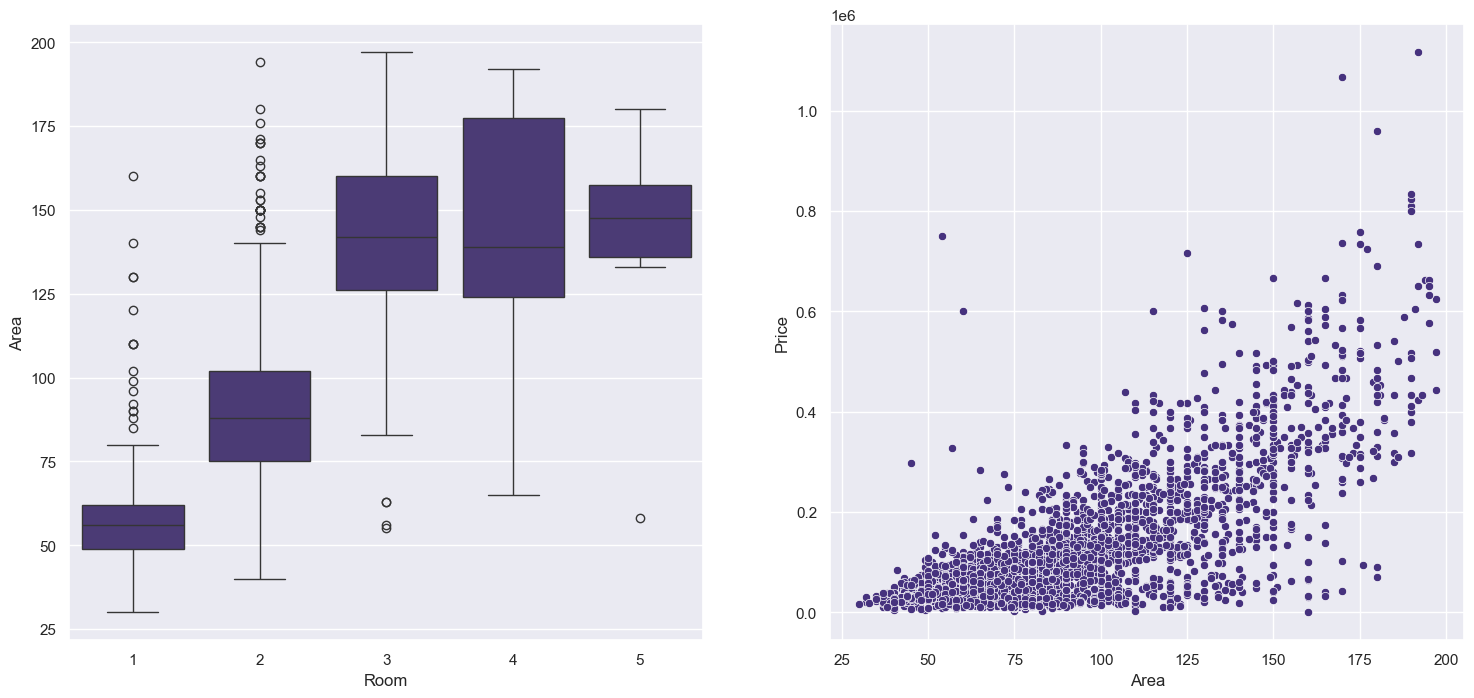

In [16]:
#Lets Explore Again
fig,axs = plt.subplots(1,2)
sns.boxplot(data=df,x='Room',y='Area',ax=axs[0])
sns.scatterplot(data=df,x='Area',y='Price',ax=axs[1])
plt.show()

The Areas with the Price seems much better than before there exist some outliers also but it seems due to some another features in data, But we found an anomaly value in 5 Rooms also with area 58 m^2 , Which is also unlogical to have a house with 5 rooms with 58 m^2

In [17]:
df.drop(index=df[(df['Area']==58)&(df['Room']==5)].index,inplace=True)

In [18]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,61666.67
1,60,1,True,True,True,Shahran,61666.67
2,79,2,True,True,True,Pardis,18333.33
3,95,2,True,True,True,Shahrake Qods,30083.33
4,123,2,True,True,True,Shahrake Gharb,233333.33


# EDA

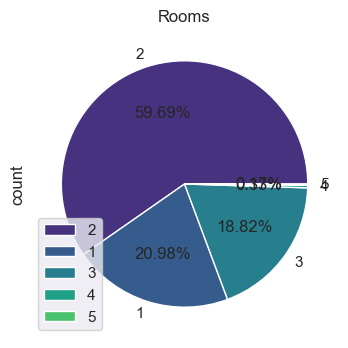

In [19]:
plt.figure(figsize=(4,4))
df['Room'].value_counts().plot(kind='pie',autopct='%.2f%%',title='Rooms')
plt.legend(loc='lower left')
plt.show()

The major number of rooms in houses : 2

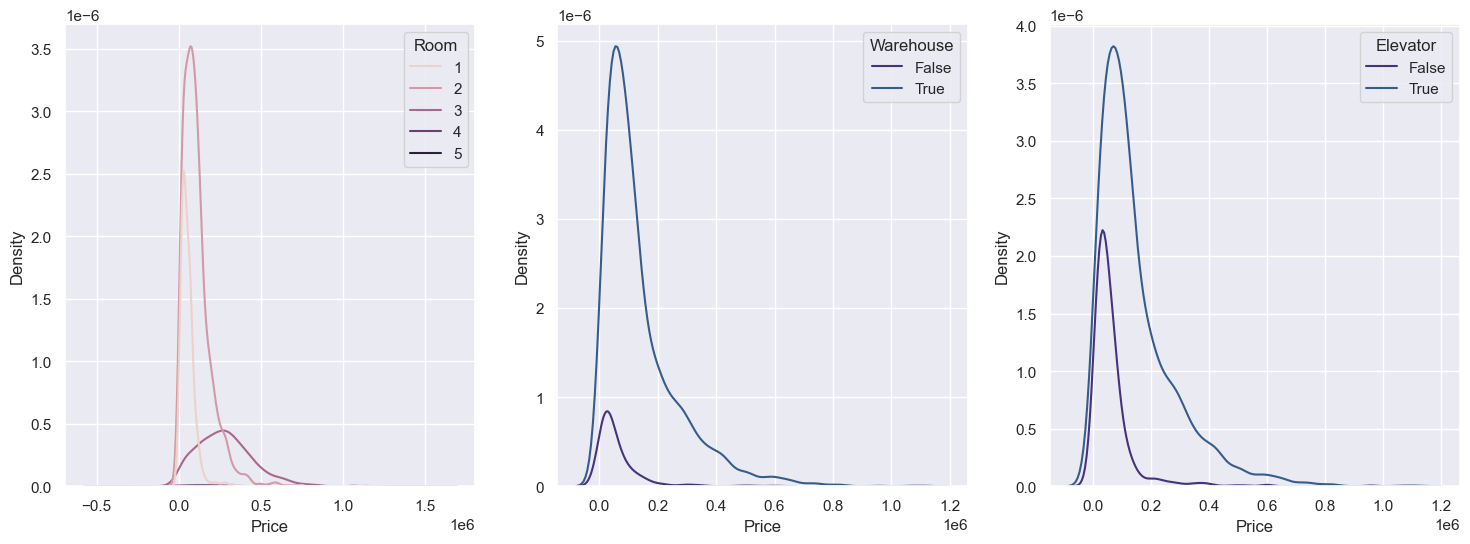

In [20]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
for idx,col in enumerate(['Room','Warehouse','Elevator']):
    sns.kdeplot(data=df,x='Price',hue=col,ax=axs[idx])

The prices between the 3 features does not differ much, But we conclude that must of houses have Elevator, Warehouse and with 1 Room

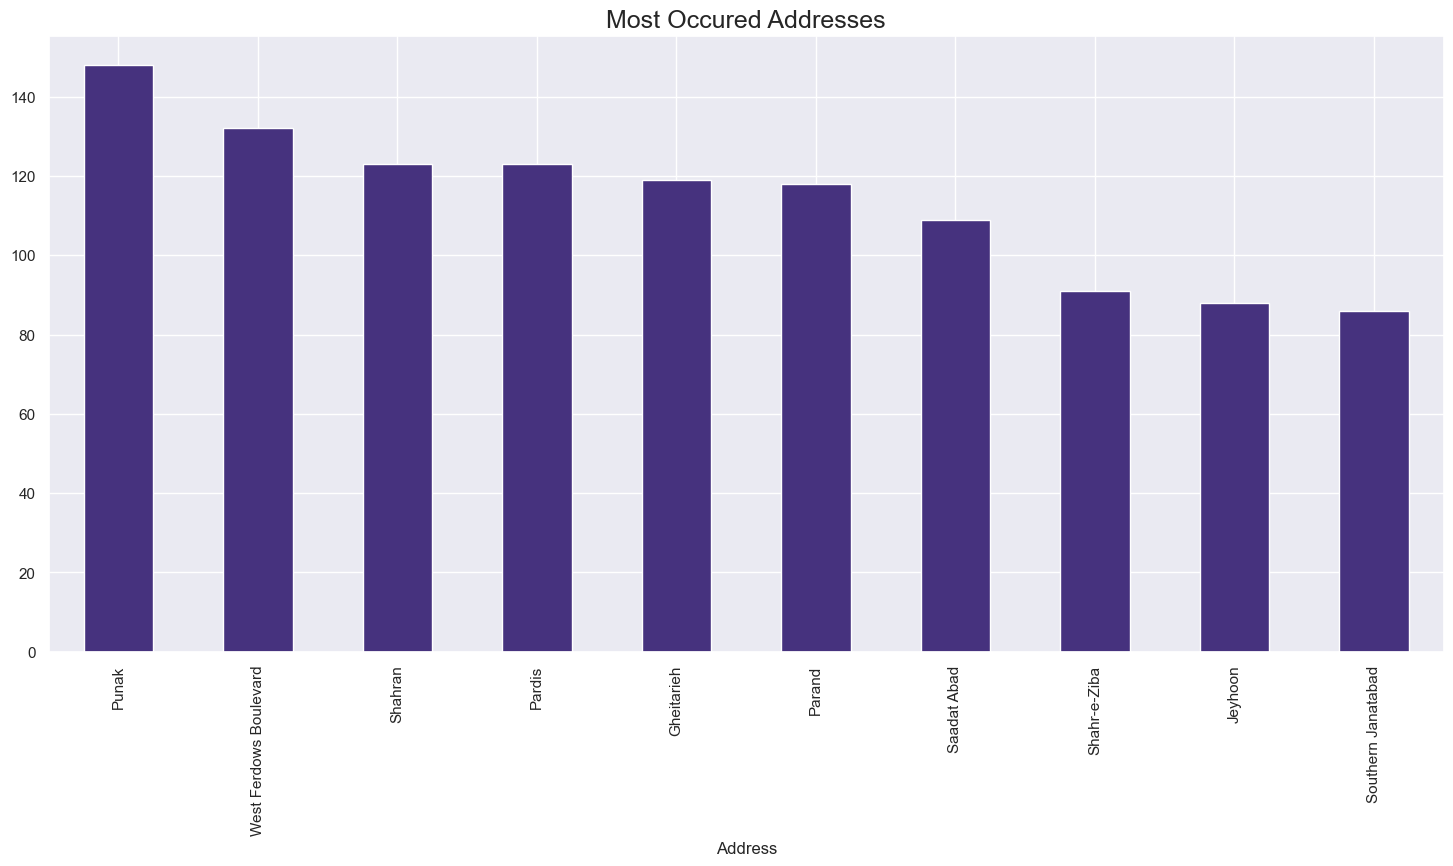

In [21]:
df['Address'].value_counts().head(10).plot(kind='bar')
plt.title('Most Occured Addresses',size=18)
plt.show()

<Axes: xlabel='Price', ylabel='Density'>

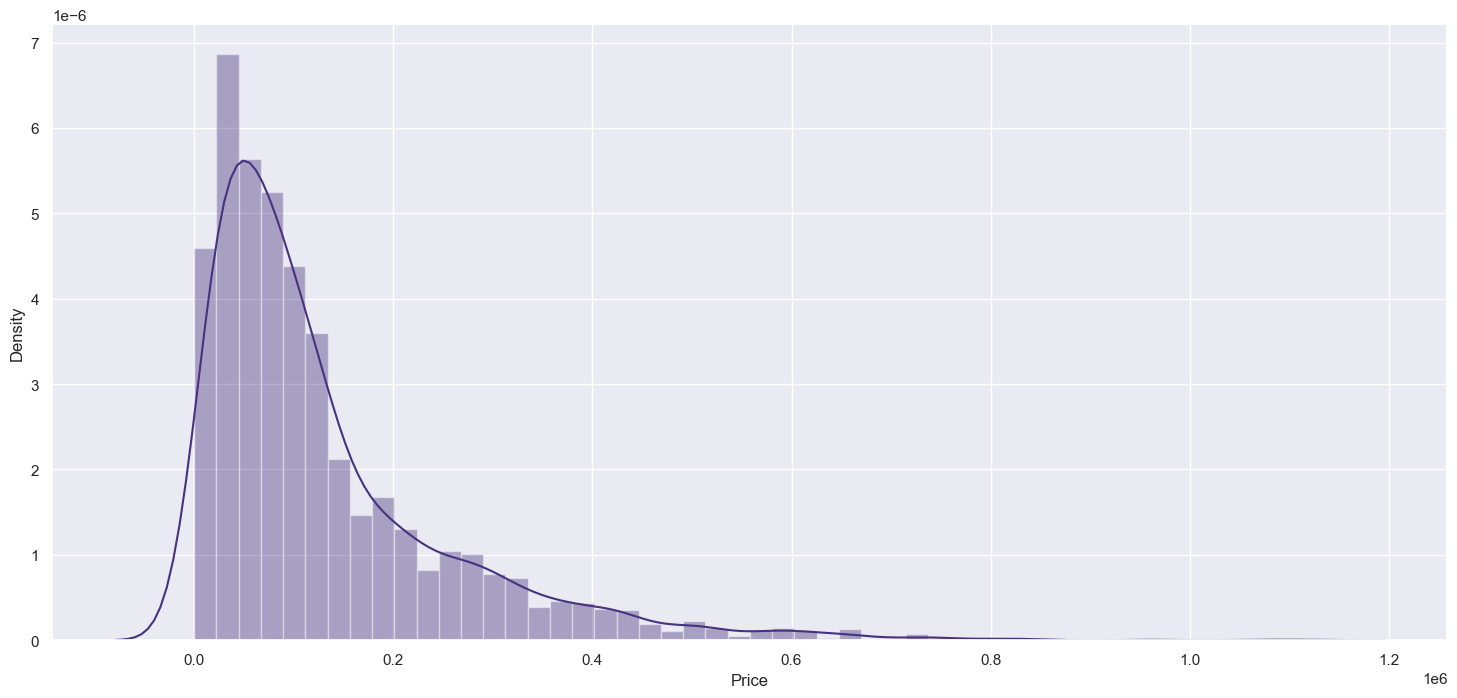

In [22]:
sns.distplot(df['Price'])

We will transform the label column (Price) due to the right skewed distribution we get in the preprocessing stage

In [23]:
#Average of houses with number of rooms (Instead of mean due to skewness in price)
pd.DataFrame(df.groupby('Room')['Price'].median()).sort_values(by='Price',ascending=False)

,Price
Room,
5,356666.670
3,266666.670
4,129333.335
2,90000.000
1,43633.330


In [24]:
#Average of houses with elevator or not
pd.DataFrame(df.groupby('Elevator')['Price'].median()).sort_values(by='Price',ascending=False)

,Price
Elevator,
True,108333.33
False,41666.67


In [25]:
#Average of houses with warehouse or not
pd.DataFrame(df.groupby('Warehouse')['Price'].median()).sort_values(by='Price',ascending=False)

,Price
Warehouse,
True,96833.335
False,34000.000


In [26]:
#Average of houses with parking or not
pd.DataFrame(df.groupby('Parking')['Price'].median()).sort_values(by='Price',ascending=False)

,Price
Parking,
True,106666.67
False,30500.00


In [27]:
#Each Address, What is the average price for it?
pd.DataFrame(df.groupby('Address')['Price'].median()).sort_values(by='Price',ascending=False).head(10)
#Remove .head(10) and see all

,Price
Address,
Zaferanieh,463333.330
Velenjak,430833.335
Dezashib,405000.000
Niavaran,403333.330
Kamranieh,385333.330
Elahieh,383333.330
Farmanieh,341333.330
Marzdaran,333333.330
Shahrake Gharb,331633.330


<Axes: >

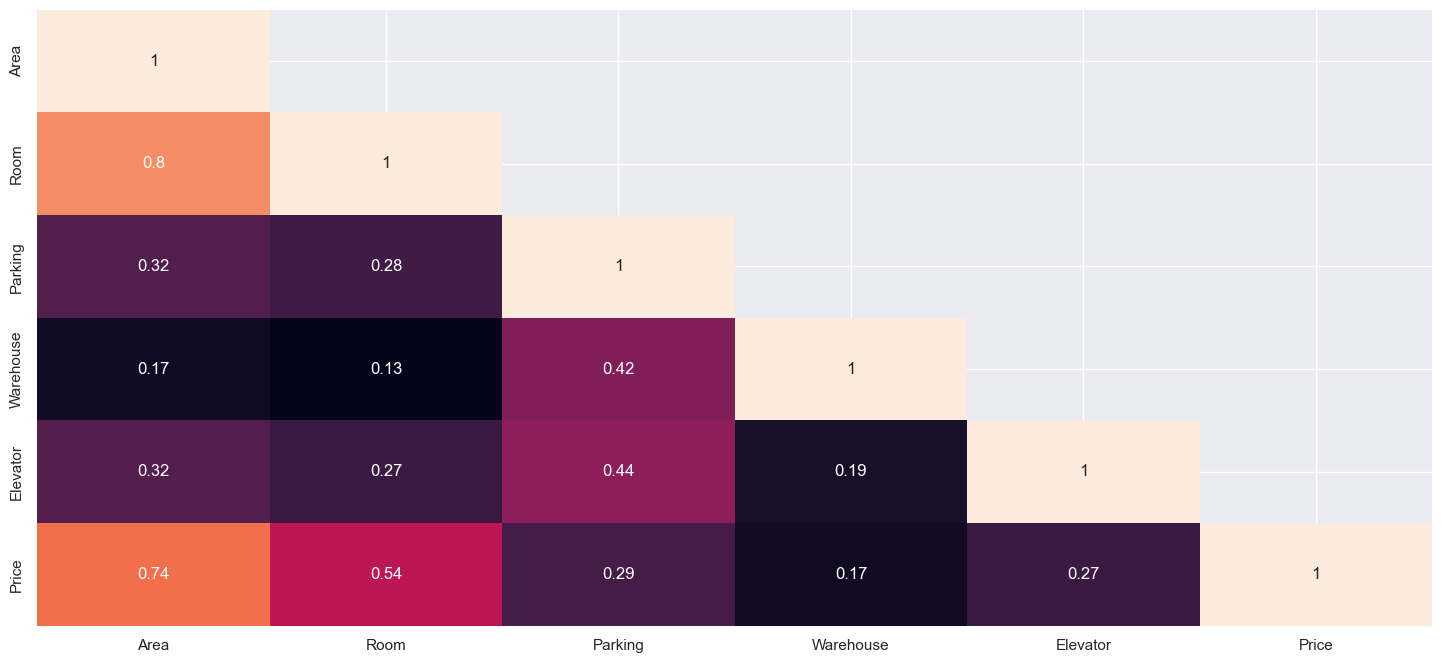

In [28]:
sns.heatmap(df.corr(numeric_only=True),
            cbar=False,
            annot=True,
           mask=np.triu(np.ones_like(df.corr(numeric_only=True),dtype=bool),k=1))

Linear relation between target and features is not (PERFECT) but it seems okay, let's see how the model deal with this

# Preprocessing

Applying Normality To (Price)
Note : This is tried before commiting this, you should tune this process to be sure of obtaining normality. 

In [29]:
preprocess_df = df.reset_index(drop=True).copy()

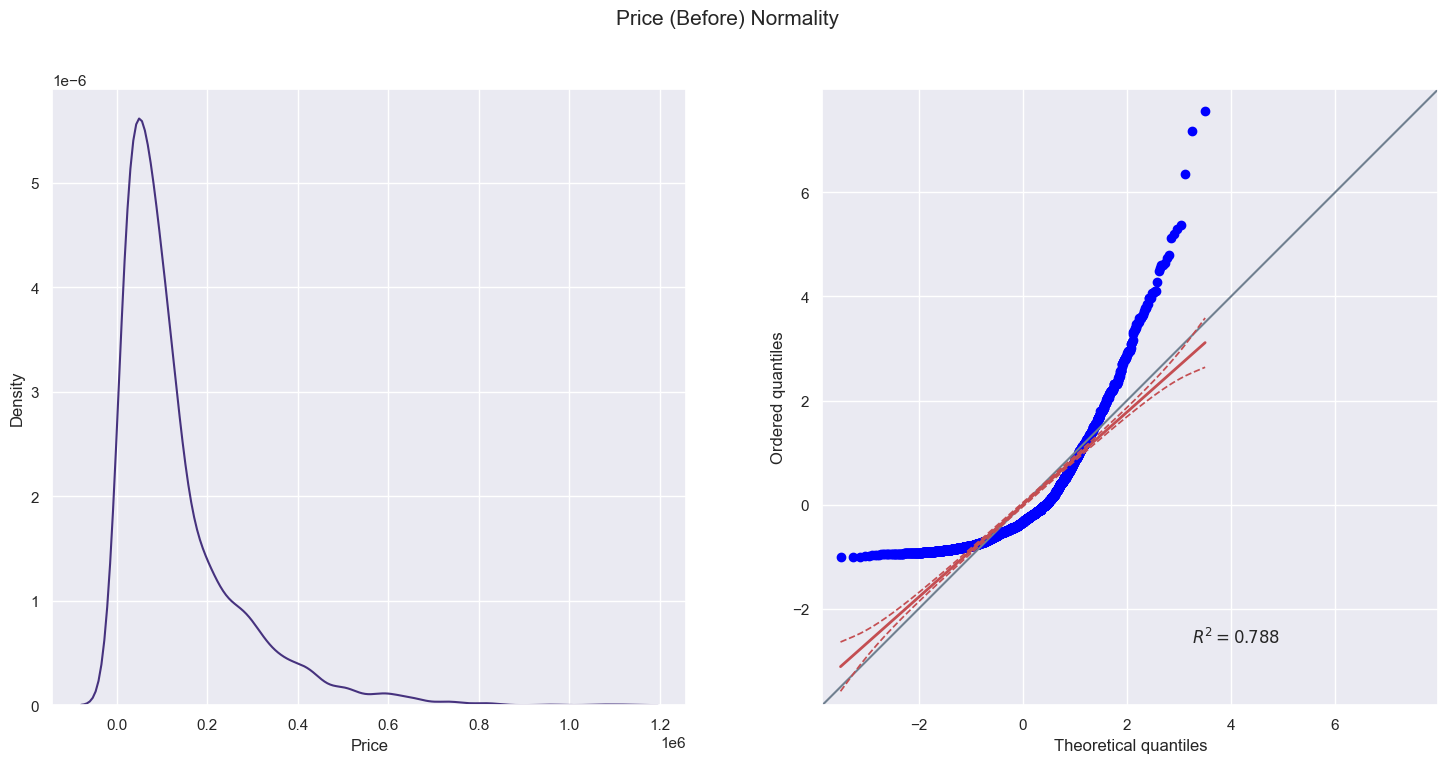

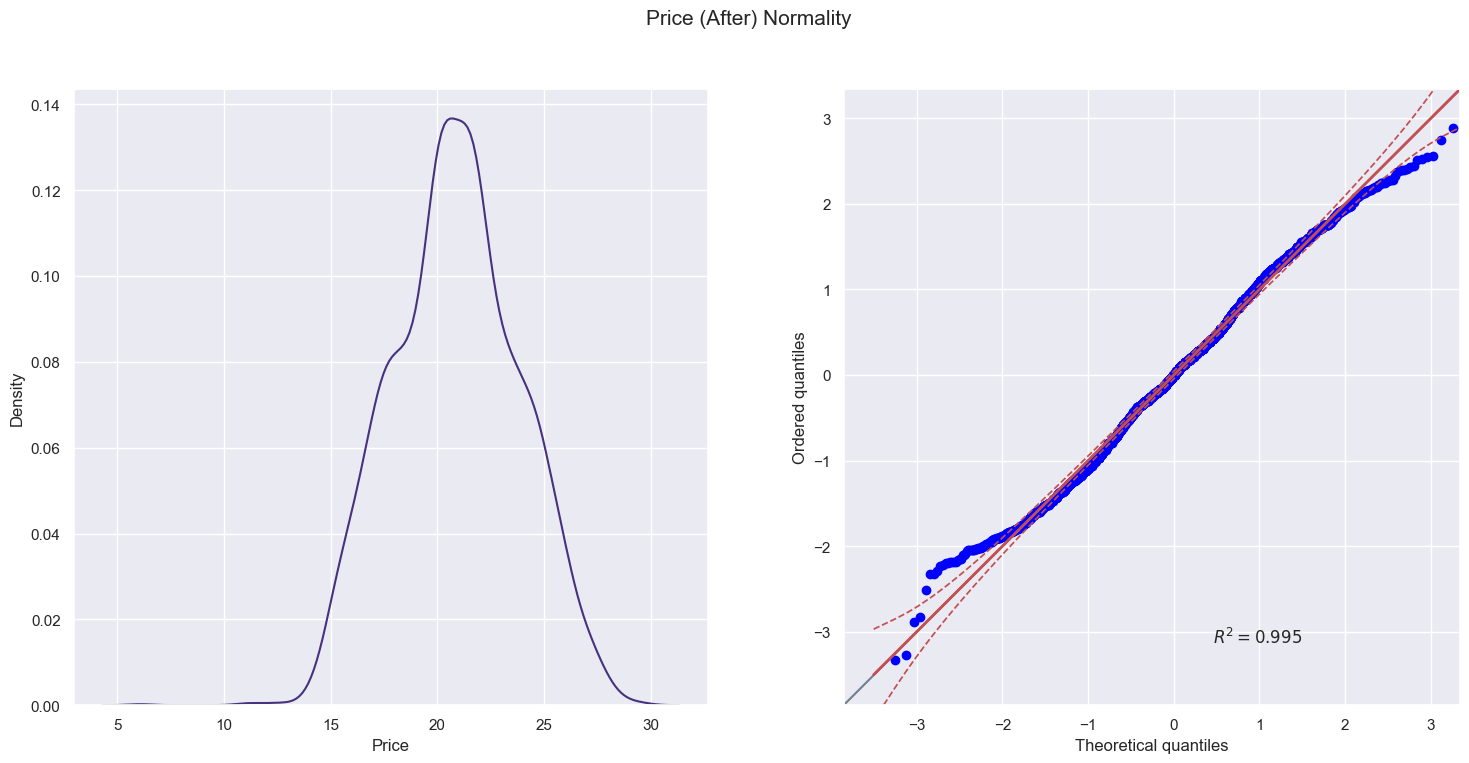

In [30]:
##Price Transformation
fig1 , axs1 = plt.subplots(1,2)
fig1.suptitle('Price (Before) Normality',size=15)
sns.kdeplot(preprocess_df['Price'],ax=axs1[0])
pingouin.qqplot(preprocess_df['Price'],ax=axs1[1])

fig2 , axs2 = plt.subplots(1,2)
fig2.suptitle('Price (After) Normality',size=15)
preprocess_df['Price'],_ = boxcox(preprocess_df['Price'])
sns.kdeplot(preprocess_df['Price'],ax=axs2[0])
pingouin.qqplot(preprocess_df['Price'],ax=axs2[1])
plt.show()

That's Good For Now! All of this to make the data suitable for linear regression, Even if decision tree or any ensemble method, it's maybe not necessary.

In [31]:
preprocess_df = pd.get_dummies(preprocess_df,columns=['Address'])

In [32]:
X = preprocess_df.drop('Price',axis=1)
Y = preprocess_df['Price']
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=10,test_size=0.2)

# Model Building & Evaluation
I use lasso model to regularize the features to prevent model overfitting and handle the presence of the few outliers and neglect some unnecessary features from the 193 features after OneHotEncoding

In [33]:
#Pipeline : Scaler -> Lasso Model
pipeline = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('model',Lasso(alpha=0.01))
    ]
)

In [34]:
kf = KFold(n_splits=5,shuffle=True)
print(cross_val_score(pipeline,x_train,y_train,cv=kf,scoring='r2'))

[0.85843586 0.90712175 0.83064698 0.87712125 0.87816425]


On unseen data, accuracy seems okay

In [35]:
pipeline.fit(x_train,y_train)
y_pred = pipeline.predict(x_test)
print('Training Accuracy :',pipeline.score(x_train,y_train).round(3)*100,'%')
print('Test Accuracy :',pipeline.score(x_test,y_test).round(3)*100 ,'%')

Training Accuracy : 90.3 %
Test Accuracy : 89.0 %


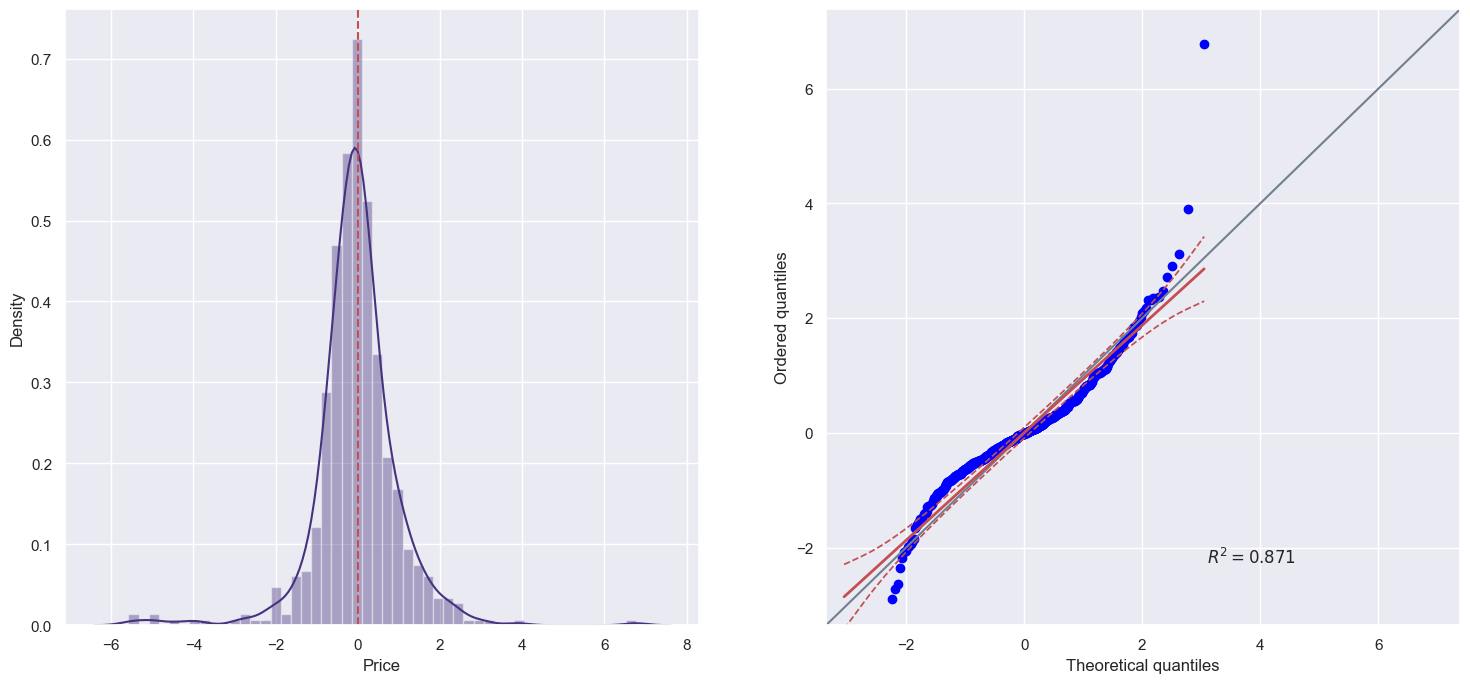

In [36]:
#Evaluation
fig, axs = plt.subplots(1,2)
sns.distplot((y_test-y_pred),ax=axs[0])
axs[0].axvline(x=0,c='r',linestyle='--')
pingouin.qqplot((y_test-y_pred),square=False,ax=axs[1])
plt.show()

The difference of residuals seems to be a normal distribution and it doesn't (PERFECT) but seems well on unseen data and assumptions on the linear model is achieved

In [37]:
#H0 (Null Hypo) : There is no sig. diff. between y_test & y_pred
#H1 (Alt. Hypo) : There is sig. diff. between y_test & y_pred
pingouin.ttest(y_test,y_pred,paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.569887,602,two-sided,0.568967,"[-0.1, 0.06]",0.008049,0.054,0.054472


Since the p_value > 0.05 (95% conf. interval) we accept null hypo. , We conclude that our model doesn't make prediction on data by change and there is no sig. diff between the pred and test